# Time and Space Variations in Met Variables
**Q1**: How does variation in meteorological variables impact averaged stability terms? Can these variations cause counter-gradient fluxes?

**Q2**: What sort of variability exists in the observations? This will be used to inform the synthetic experiment on counter-gradient fluxes.

In [2]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# -------------------------------------------------------------------------------------------------------
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xray
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('talk')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import kgraph
import turbpy
import turbpy.multiConst as mc

# -------------------------------------------------------------------------------------------------------
# Directory Lists
# -------------------------------------------------------------------------------------------------------
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'  # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirData = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'  # Processed data directory

## Define Functions

In [3]:
def gradRichardson(# input
                    airTemp,                # air temperature (K) corresponding to heights N
                    windSpd,                # wind speeds (m s^-1) corresponding to heights N
                    mHeight                 # measurement heights (m) of wind and air temperature
                    ):
# -------------------------------------------------------------------------------------------------------
    # Sub-function
    def logGrad(x1,x2,z1,z2):
        # Log gradient function
        mid = np.exp((np.log(z1) + np.log(z2))/2)
        grad = 1/mid * ((x2 - x1)/(np.log(z2)-np.log(z1)))
        return grad,mid
# -------------------------------------------------------------------------------------------------------

    #########
    # Constants/Parameters
    g = 9.81                                # gravitational acceleration (m s^-2)
    numL = mHeight.size                     # Number of layers
    
    #########
    # Difference each heigh using logGrad
    gradWind = np.zeros(numL-1)             # Gradient in wind
    zMid = np.zeros(numL-1)                 # Log-averaged height beetween layers
    gradTheta = np.zeros(numL-1)            # Gradient in virtual temperature
    thetaMid = np.zeros(numL-1)             # "virtual" temperature at the mid-point between levels
    
    for k in np.arange(0,numL-1):
        (grad_u[k],zm[k]) = logGrad(u[k],u[k+1],z[k],z[k+1])
        (grad_theta[k],zm[k]) = logGrad(theta[k],theta[k+1],z[k],z[k+1])
        theta_m[k] = np.exp((np.log(theta[k]) + np.log(theta[k+1]))/2)

    # Calculate the gradient Richardson Number
    gradRi = g/theta_m * (grad_theta/grad_u**2)
    gradRiMean = np.mean(gradRi)
    return(gradRi,gradRiMean)

## Notes
Calculating z0 and the Obukhov length using the gradient Ri number

###### Gradients
Calculate the gradients in $u$ and $\theta$ between each layer using the expression:

$\frac{\Delta u}{\Delta z} = \frac{1}{z_m} \frac{u_{z2} - u_{z1}}{ln(z2)-ln(z1)} $

where $z_m$ is the average of the log heights $\frac{ln(z1) + ln(z2)}{2}$ and $u$ can be exchanged with $\theta$

###### gradient Richardson Number
$Ri = \frac{-d\theta}{dz} \frac{du}{dz}^{-2} $

$ b = g\theta_m/\theta $

#### Friction Velocity
First finding the friction velocity, ($u_*$)

Given that $\Phi_h = \Phi_M^2 = 1-16 \frac{z}{L} $ (e.g., $\gamma_1 = 16$)

Equation 6.2 from the notes
$kz/u_{*} \frac{du}{dz} = \Phi_m(\frac{z}{L})$

Solve for $u_{*}$:

$kz/\Phi_m(\frac{z}{L}) \frac{du}{dz} = u_{*}$

#### Surface Roughness
Finding the surface roughness using equation 6.14 from the class notes.

$u(z) = \frac{u_*}{k} (\ln( \frac{z}{z_0}) - \Psi_m(\frac{z}{L})) $ (eq. 6.14)

where $\Psi_m = log(\frac{1+x^2}{2}\frac{1+x}{2}^2) - 2 \tan^-1(x) + \pi/2$

and $x = (1-\gamma_1 \frac{z}{L})^{1/4}$

solving for $z_0$

$z_0 = z/ \exp(\frac{k u(z)}{u_*} + \Psi_m)$ 

In [4]:
# -------------------------------------------------------------------------------------------------------
# Open netcdfs
# -------------------------------------------------------------------------------------------------------
os.chdir(dirData)
# 5 minute values
Atower = xray.open_dataset('SCP.Atower.netcdf')
Ctower = xray.open_dataset('SCP.Ctower.netcdf')
Mtower = xray.open_dataset('SCP.Mtower.netcdf')
soilObs = xray.open_dataset('SCP.soil_obs.netcdf')
radObs = xray.open_dataset('SCP.rad_obs.netcdf')
fluxObs = xray.open_dataset('SCP.flux_obs.netcdf')
# 30m averages
fluxObs_30m = xray.open_dataset('SCP.flux_obs_30m.netcdf')
radObs_30m = xray.open_dataset('SCP.rad_obs_30m.netcdf')
soilObs_30m = xray.open_dataset('SCP.soil_obs_30m.netcdf')

In [5]:
########
# Surface temperature from upwelling longwave
sigma = 5.67*10**-8.                   # Stefan-Boltzmann constant
Tsfc = (radObs.Rlw_out/sigma)**(1./4.)

# Insert into Mtower xarray.Dataset
Mtower['Tsfc'] = (('time'), Tsfc-273.15)

########
# Bulk Richardson Number
Mtower['UBar_15m'] = (('time'), (Mtower.U_15m_M**2+Mtower.V_15m_M**2)**(1./2.))
Mtower.UBar_15m[Mtower.UBar_15m > 10] = np.nan
Mtower['UBar_2m'] = (('time'), (Mtower.u_2m_M**2+Mtower.v_2m_M**2)**(1./2.))
Mtower.UBar_15m[Mtower.UBar_2m > 10] = np.nan

RiBulk_15m,_,_ = turbpy.bulkRichardson(Mtower.T_15m_M+273.15,Mtower.Tsfc+273.15,Mtower.UBar_15m,15.)
Mtower['RiBulk_15m'] = RiBulk_15m
RiBulk_2m,_,_ = turbpy.bulkRichardson(Mtower.T_1m_M+273.15,Mtower.Tsfc+273.15,Mtower.UBar_2m,2.)
Mtower['RiBulk_2m'] = RiBulk_2m

# Stability parameter variability

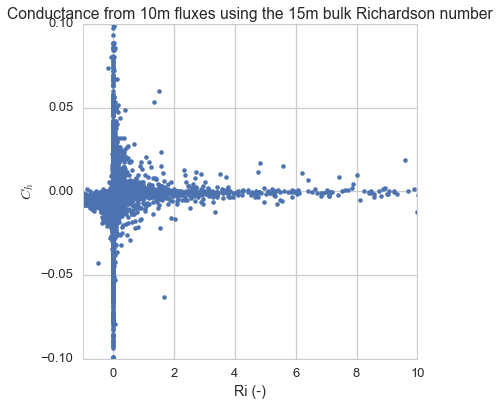

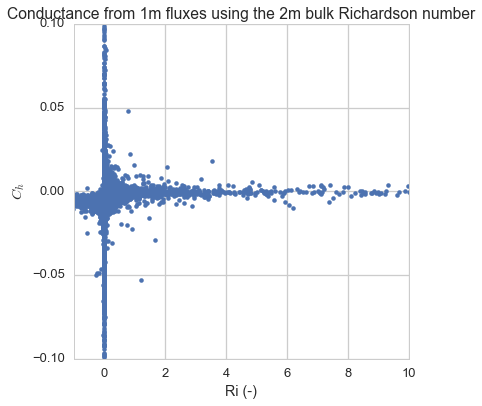

In [6]:
volHeatCapacityAir = mc.iden_air*mc.Cp_air           # volumetric heat capacity of air (J m-3)

Cobs_15m = fluxObs.w_tc__10m_M / (-volHeatCapacityAir*(Mtower.Tsfc-Mtower.T_15m_M))
Cobs_2m = fluxObs.w_tc__2m_M / (-volHeatCapacityAir*(Mtower.Tsfc-Mtower.T_1m_M))

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(Mtower.RiBulk_2m,Cobs_15m,'.')
ax.set_ylim(-.1,.1)
ax.set_xlim(-1,10)
ax.set_xlabel('Ri (-)')
ax.set_ylabel('$C_h$')
ax.set_title('Conductance from 10m fluxes using the 15m bulk Richardson number')

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(Mtower.RiBulk_2m,Cobs_2m,'.')
ax.set_ylim(-.1,.1)
ax.set_xlim(-1,10)
ax.set_xlabel('Ri (-)')
ax.set_ylabel('$C_h$')
ax.set_title('Conductance from 1m fluxes using the 2m bulk Richardson number')

Just as a test I tried to invert for the conductance, $C_h$ using observations:

$Q_h = C_h c \rho (T_{air} - T_{sfc})$

$C_h = \frac{Q_h}{ c \rho (T_{air} - T_{sfc})}$

However, when solving for $C_h$ using this method, I find that the conductance contains a number of negative values in the positive regime. This is a strange result that I will need to think on.

Further action could include averaging for each bulk Richardson number and seeing if the curves match those plotted in Figure 1 of Mahrt 1987.

In [7]:
# Aggregate
RiBulk = xray.Dataset()
RiBulk['15m_mean'] = RiBulk_15m.resample(how='mean',dim='time',freq='H')
RiBulk['15m_std'] = RiBulk_15m.resample(how='std',dim='time',freq='H')
RiBulk['2m_mean'] = RiBulk_2m.resample(how='mean',dim='time',freq='H')
RiBulk['2m_std'] = RiBulk_2m.resample(how='std',dim='time',freq='H')

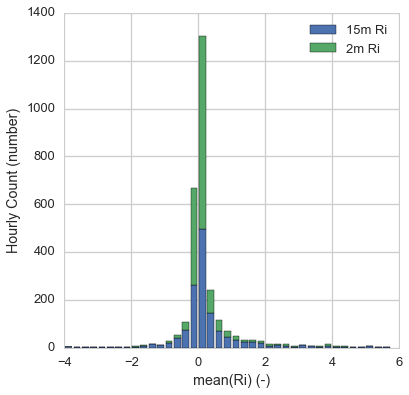

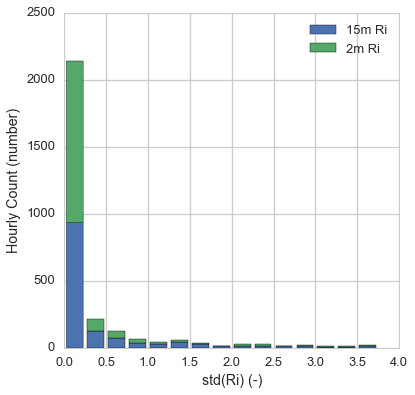

In [9]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist([RiBulk['15m_mean'].dropna(dim='time').values,
         RiBulk['2m_mean'].dropna(dim='time').values],
         bins=np.arange(-4, 6, .25), stacked=True, label=['15m Ri', '2m Ri']);
ax.set_ylabel('Hourly Count (number)')
ax.set_xlabel('mean(Ri) (-)')
ax.legend()

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist([RiBulk['15m_std'].dropna(dim='time').values,
         RiBulk['2m_std'].dropna(dim='time').values],
        bins=np.arange(0, 4, .25), stacked=True, label=['15m Ri', '2m Ri']);
ax.set_ylabel('Hourly Count (number)')
ax.set_xlabel('std(Ri) (-)')
ax.legend()

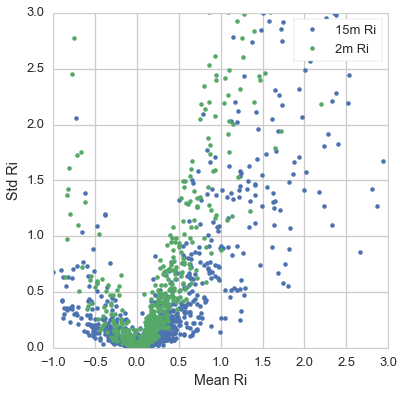

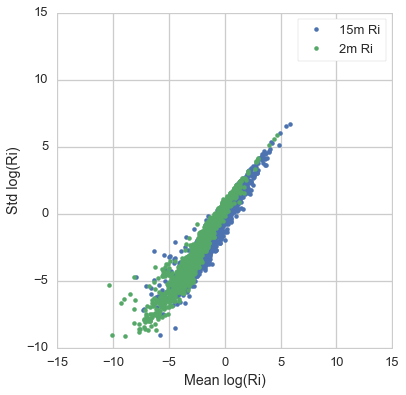

In [15]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(RiBulk['15m_mean'], RiBulk['15m_std'], '.', label='15m Ri')
ax.plot(RiBulk['2m_mean'], RiBulk['2m_std'], '.', label='2m Ri')
ax.set_xlim(-1, 3)
ax.set_ylim(0, 3)
ax.set_xlabel('Mean Ri')
ax.set_ylabel('Std Ri')
ax.legend(frameon=True)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(np.log(RiBulk['15m_mean']), np.log(RiBulk['15m_std']), '.', label='15m Ri')
ax.plot(np.log(RiBulk['2m_mean']), np.log(RiBulk['2m_std']), '.', label='2m Ri')
# ax.set_xlim(-1, 3)
# ax.set_ylim(0, 3)
ax.set_xlabel('Mean log(Ri)')
ax.set_ylabel('Std log(Ri)')
ax.legend(frameon=True)

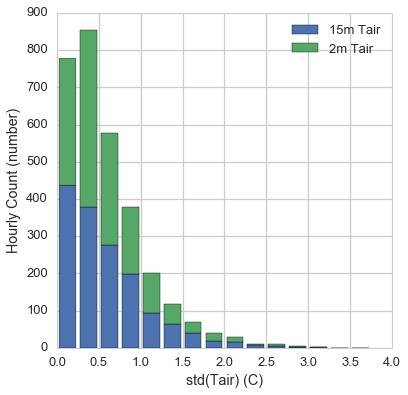

In [16]:
Tair_15m_mean = Mtower.T_15m_M.resample(how='mean', dim='time', freq='H')
Tair_15m_std = Mtower.T_15m_M.resample(how='std', dim='time', freq='H')
Tair_2m_mean = Mtower.T_1m_M.resample(how='mean', dim='time', freq='H')
Tair_2m_std = Mtower.T_1m_M.resample(how='std', dim='time', freq='H')

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist([Tair_15m_std.dropna(dim='time').values,
         Tair_2m_std.dropna(dim='time').values],
        bins = np.arange(0,4,.25), stacked=True, label=['15m Tair', '2m Tair']);
ax.set_ylabel('Hourly Count (number)')
ax.set_xlabel('std(Tair) (C)')
ax.legend()

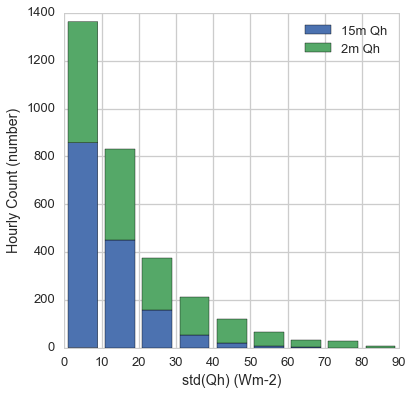

In [18]:
Qh_15m_mean = fluxObs.w_tc__2m_M.resample(how='mean', dim='time', freq='H')
Qh_15m_std = fluxObs.w_tc__2m_M.resample(how='std', dim='time', freq='H')
Qh_2m_mean = fluxObs.w_tc__10m_M.resample(how='mean', dim='time', freq='H')
Qh_2m_std = fluxObs.w_tc__10m_M.resample(how='std', dim='time', freq='H')

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist([Qh_15m_std.dropna(dim='time').values,
         Qh_2m_std.dropna(dim='time').values],
        bins=np.arange(0, 100, 10), stacked=True, label=['15m Qh', '2m Qh']);
ax.set_ylabel('Hourly Count (number)')
ax.set_xlabel('std(Qh) (Wm-2)')
ax.legend()

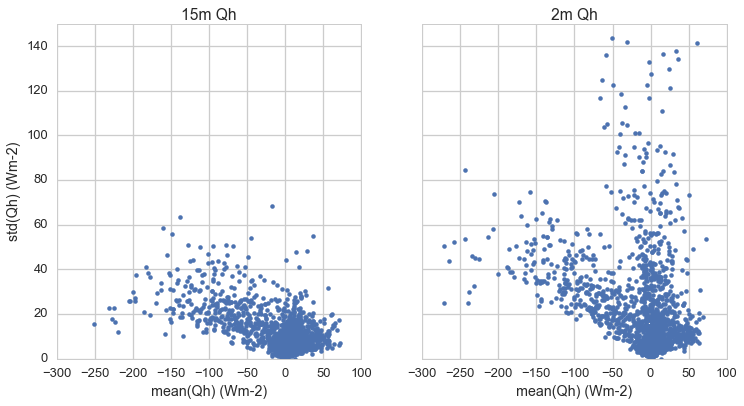

In [20]:
fig, axes = plt.subplots(1,2,figsize=(12,6),sharey=True)
ax = axes[0]
ax.plot(-Qh_15m_mean, Qh_15m_std,'.',label='15m Ri')
ax.set_title('15m Qh')
ax.set_ylim(0,150)
ax.set_ylabel('std(Qh) (Wm-2)')
ax.set_xlabel('mean(Qh) (Wm-2)')

ax = axes[1]
ax.plot(-Qh_2m_mean, Qh_2m_std,'.',label='2m Ri')
ax.set_title('2m Qh')
ax.set_ylim(0,150)
ax.set_xlabel('mean(Qh) (Wm-2)')

# Future Steps
- Add analysis of spatial variability in Tair/Qh/stability/conductance across SCP site
- Add Snoqualmie: Tsrf1 vs Tsrf2, look at raw EC obs (time averaging assumptions, variations in Tair)